# Import libraries and data

In [1]:
import os
import sys
import pickle
import gensim
import spec2vec
import numpy as np
import pandas as pd

np.random.seed(42)

import seaborn as sns
from matplotlib import pyplot as plt

from processing import get_ids_for_unique_inchikeys

In [2]:
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
model_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Model/"

# For now, we are only using the spectra that were obtained in positive ion-mode
pretrained_model = gensim.models.Word2Vec.load(model_dir+"ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_spec2vec_embedding_iter_15.model")
with open(data_dir+"ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups_peaks_processed_s2v.pickle", 'rb') as file:
    spectra = pickle.load(file)

# Load the class predictions for each inchikey and shorten the inchikey to the first 14 characters. In case of duplicates, we keep the first occurence and drop the others.
# We only use the first 14 characters of the inchikey (the so-called planar inchikey) because MS spectra cannot be used to meaningfully distinguish compounds beyond these features.
inchikey_classifications = pd.read_csv(data_dir+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 
inchikey_classifications["inchikey"] = [key[:14] for key in inchikey_classifications["inchikey"]]
inchikey_classifications.drop_duplicates(subset = "inchikey", keep="first", inplace = True)

In [19]:
def colour_dict(var_column):
    # Creates a colour dictionary with 22 distinct colours for seaborn plots. 
    # If the number of groups in the variable column exceeds 22, the largest groups will be given the distinct colours. Every group after that will be marked with black.
    # If the number of groups is smaller than 22, the first n colours will be used. 
    colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#000000', '#FFFFFF']
    
    groups = list(spectrum_metadata[hue_var].value_counts(ascending=False).index)
    while (len(groups) > len(colours)):
           colours.append("#000000")
    colour_dict = dict(zip(groups, colours))
    return colour_dict

# Retrieve metadata and calculate vectors

In [ ]:
# What metadata do we have?
spectra[0].metadata

In [4]:
# We retrieve the inchikey and source instrument for all spectra, and look up the predicted classes for the inchikey.
# Again, we only keep the first 14 characters of the inchikeys. 
inchikeys = []
instruments = []
for spec in spectra:
    short_inchikey = spec.get("inchikey")[:14]
    inchikeys.append(short_inchikey)
    instruments.append(spec.get("source_instrument"))
spectrum_metadata = pd.DataFrame({"inchikey":inchikeys, "instrument": instruments})

In [5]:
# We drop all spectral records without inchikey and match the remaining records with npclassifier and classyfire compound class predictions
spectrum_metadata = spectrum_metadata[spectrum_metadata["inchikey"] != ""]
spectrum_metadata = spectrum_metadata.merge(inchikey_classifications, on = "inchikey", how = "left")
spectra = [spectra[i] for i in spectrum_metadata.index]

In [6]:
# Retrieve SpectrumDocuments and convert to vectors
spectrum_documents = [spec2vec.SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectra)]
spectrum_vectors = pd.DataFrame([spec2vec.calc_vector(pretrained_model, document) for i, document in enumerate(spectrum_documents)])

In [7]:
# We retrieve the IDs of spectra with unique Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(spectra)

In [8]:
# And clear out the data we don't need anymore
del(inchikeys, instruments, spectra, spectrum_documents)

In [9]:
# This is what the metadata we've collected looks like for the first three spectra
# The class predictions are split up between two different classifiers, ClassyFire (cf), and NPClassifier (npc)
spectrum_metadata.iloc[0:3,:].T

,0,1,2
inchikey,IYDKWWDUBYWQGF,KNGPFNUOXXLKCN,WXDBUBIFYCCNLE
instrument,LC-ESI-qTof,LC-ESI-qTof,LC-ESI-Ger
smiles,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
cf_kingdom,Organic compounds,Organic compounds,Organic compounds
cf_superclass,Organic acids and derivatives,Organic acids and derivatives,Organoheterocyclic compounds
cf_class,Peptidomimetics,Peptidomimetics,Oxepanes
cf_subclass,Hybrid peptides,Depsipeptides,NaN
cf_direct_parent,Hybrid peptides,Cyclic depsipeptides,Oxepanes
npc_class_results,Cyclic peptides; Microcystins,Cyclic peptides,Lipopeptides
npc_superclass_results,Oligopeptides,Oligopeptides,Oligopeptides


# Reduce dimensions with UMAP and t-SNE

For these visualizations we haven't applied any filtering based on Inchikey or metadata. This means most of what we see will be "Lipids and lipid-like molecules", according to the ClassyFire superclasses.

In [10]:
spectrum_metadata["npc_superclass_results"].value_counts(ascending = False)

Glycerophospholipids                                  13671
Flavonoids                                             6780
Steroids                                               4889
Tryptophan alkaloids                                   3683
Triterpenoids                                          3323
                                                      ...  
Tropolones                                                1
Pseudoalkaloids (transamidation); Lysine alkaloids        1
Fatty esters; Diterpenoids                                1
Anthranilic acid alkaloids; Peptide alkaloids             1
Diarylheptanoids; Phenylpropanoids (C6-C3)                1
Name: npc_superclass_results, Length: 160, dtype: int64

In [11]:
import umap

# Reduce dimensions with umap
umap_df = pd.DataFrame(umap.UMAP(n_components=2, min_dist = 0.3).fit_transform(spectrum_vectors), columns = ["x", "y"]); umap_df.index = spectrum_metadata.index
umap_df = pd.concat([umap_df, spectrum_metadata], axis = 1)

In [12]:
from sklearn.manifold import TSNE

# Reduce dimensions with t-SNE
tsne_df = pd.DataFrame(TSNE(n_components=2).fit_transform(spectrum_vectors), columns = ["x", "y"]); tsne_df.index = spectrum_metadata.index
tsne_df = pd.concat([tsne_df, spectrum_metadata], axis = 1)

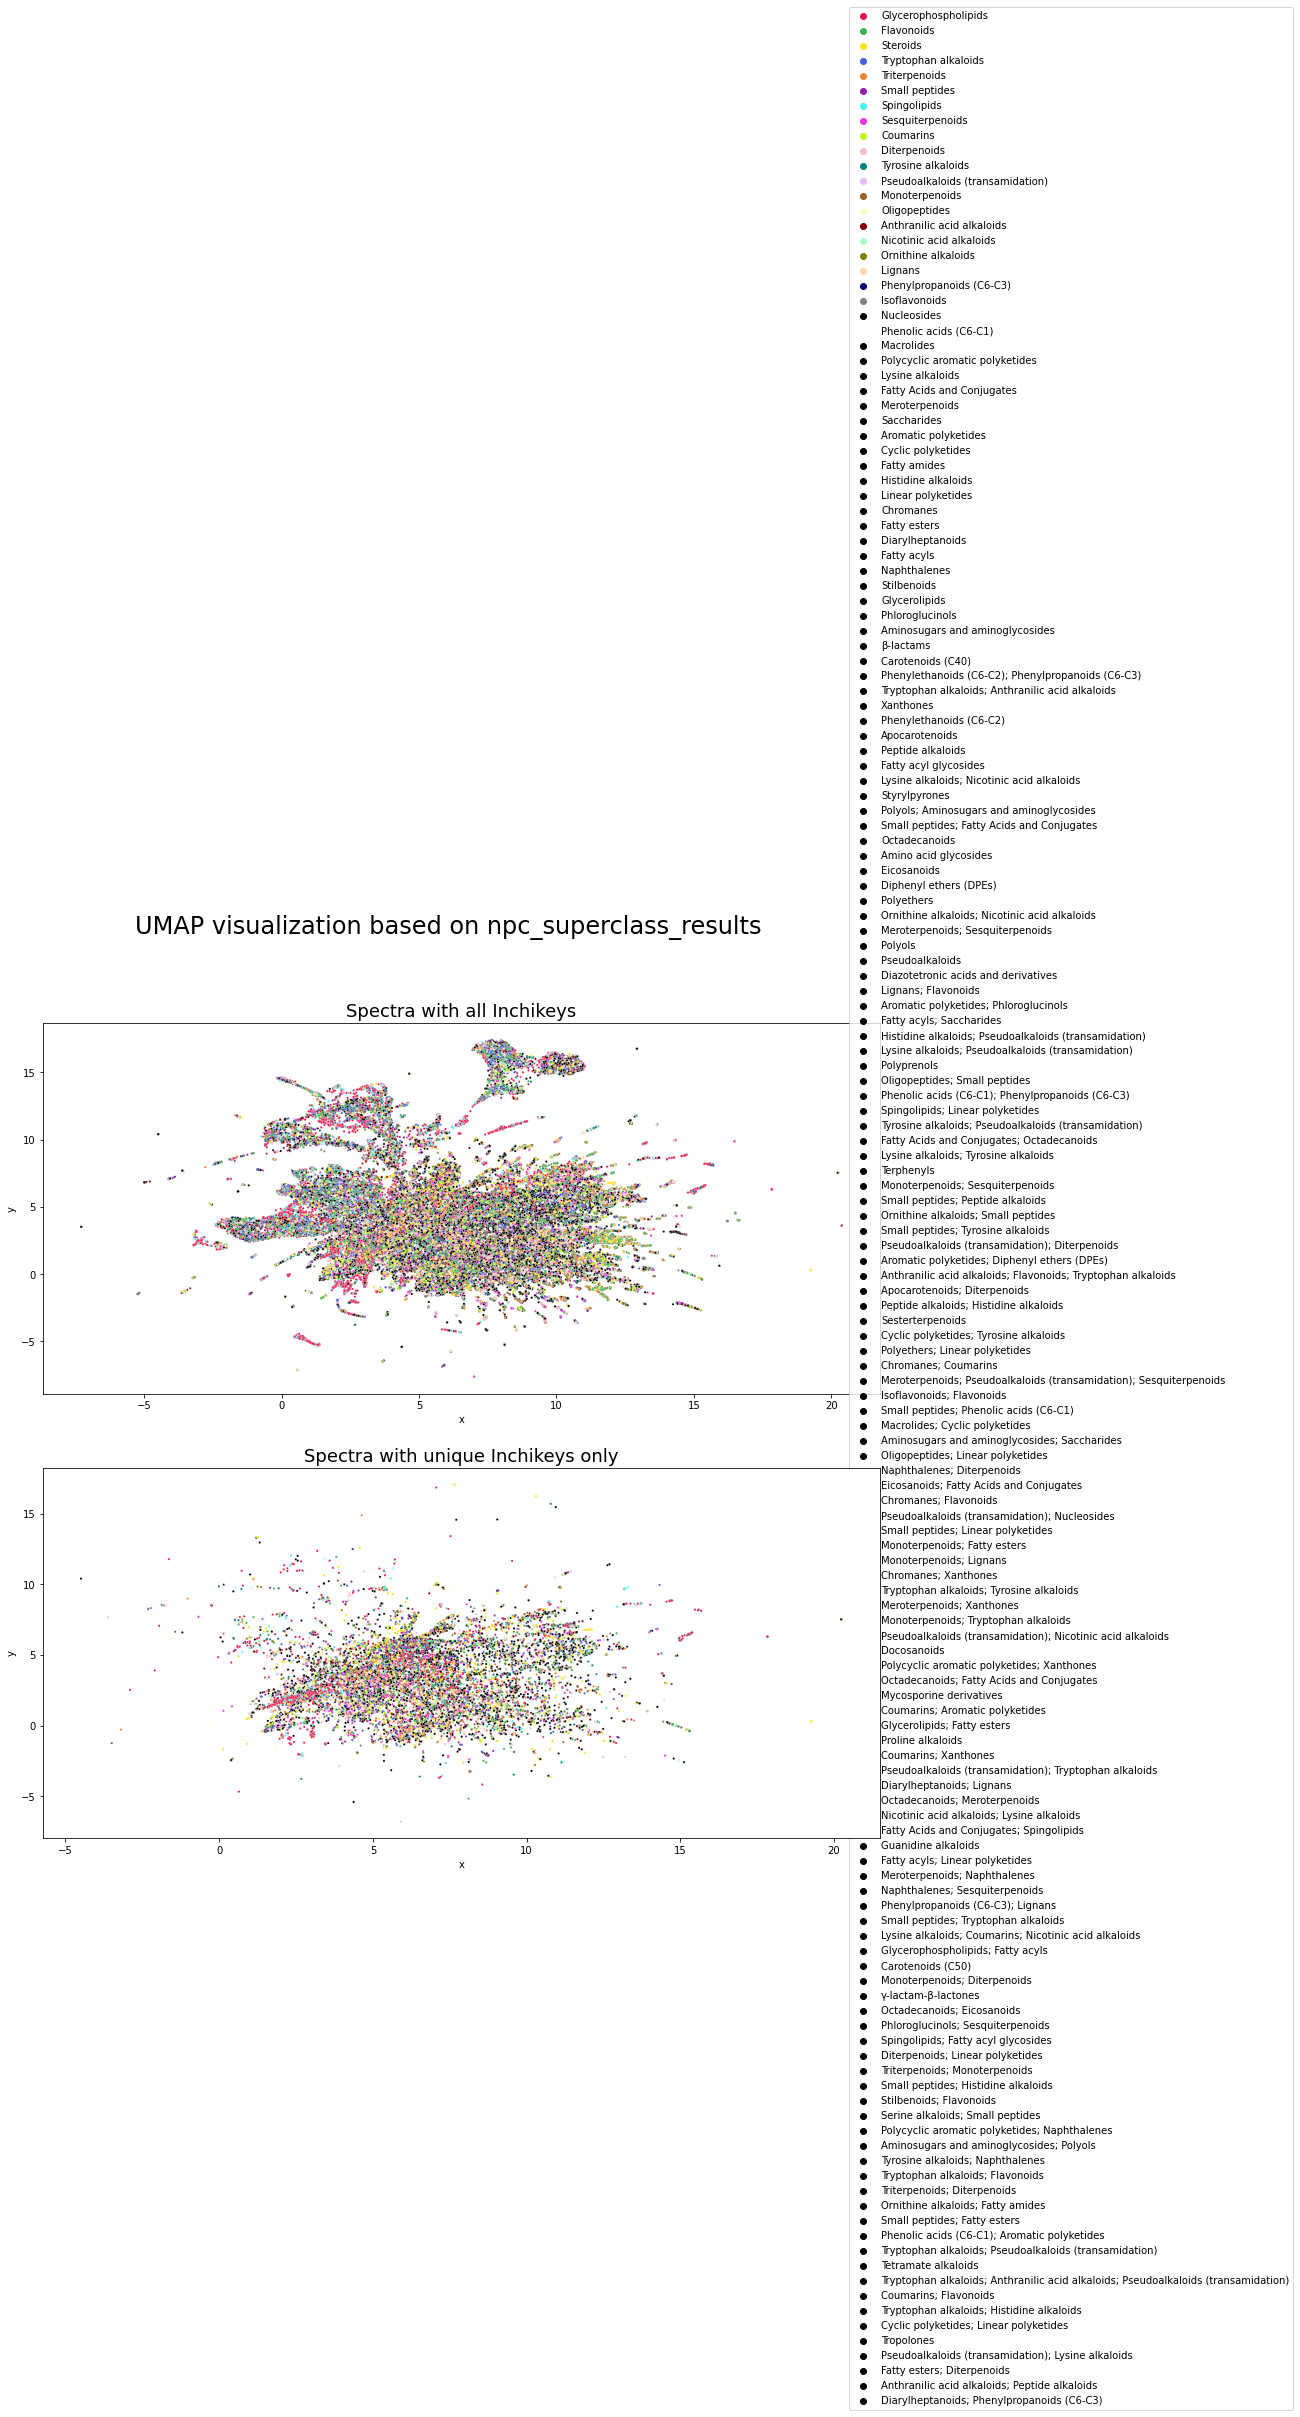

In [20]:
# Plot UMAP
from collections import OrderedDict 
hue_var = "npc_superclass_results"

fig, ax = plt.subplots(2, figsize=(15,15)); fig.suptitle('UMAP visualization based on %s' %hue_var, fontsize = 24)
sns.scatterplot(data = umap_df, x="x", y="y", hue = hue_var, palette = colour_dict(spectrum_metadata[hue_var]), alpha = 1, s=5, ax = ax[0]).set_title("Spectra with all Inchikeys", fontsize = 18)
sns.scatterplot(data = umap_df.iloc[unique_inchi,:], x="x", y="y", hue = hue_var, palette = colour_dict(spectrum_metadata[hue_var]), alpha = 1, s=5, ax = ax[1], legend=False).set_title("Spectra with unique Inchikeys only", fontsize = 18)

# Sort and move legend
handles, labels = ax[0].get_legend_handles_labels()
by_label_unsorted = dict(zip(labels, handles))
by_label = OrderedDict([(lab, by_label_unsorted[lab]) for lab in spectrum_metadata[hue_var].value_counts(ascending = False).index])
ax[0].legend(by_label.values(), by_label.keys(), loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1)

Text(0.5, 1.0, 'Spectra with unique Inchikeys only')

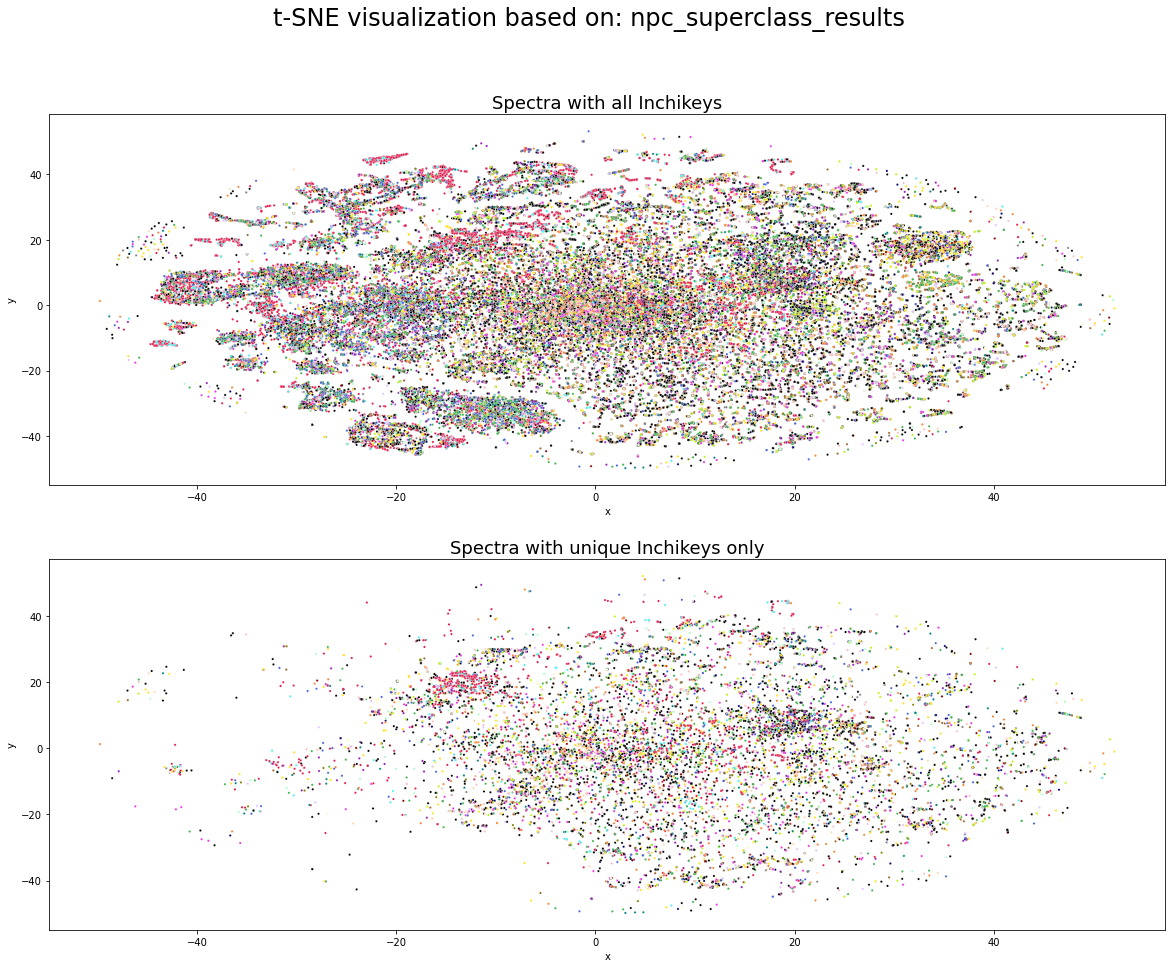

In [21]:
# Plot t-SNE
hue_var = "npc_superclass_results"

fig, ax = plt.subplots(2, figsize=(20,15)); fig.suptitle('t-SNE visualization based on: %s' %hue_var, fontsize = 24)
sns.scatterplot(data = tsne_df, x="x", y="y", hue = hue_var, palette = colour_dict(spectrum_metadata[hue_var]), alpha = 1, s=5, ax = ax[0], legend=False).set_title("Spectra with all Inchikeys", fontsize = 18)
sns.scatterplot(data = tsne_df.iloc[unique_inchi,:], x="x", y="y", hue = hue_var, palette = colour_dict(spectrum_metadata[hue_var]), alpha = 1, s=5, ax = ax[1], legend=False).set_title("Spectra with unique Inchikeys only", fontsize = 18)

# How well do compound classes cluster together?

To investigate to what degree NPClassifier superclasses cluster together, we will filter for the most frequently reported instrument type to control for variation introduced by instrument type. 

In [86]:
instrument_type = ["ToF", "CID", "HCD"]
for instrument in instrument_type:
    print(instrument, ":", sum(spectrum_metadata["instrument"].str.contains(instrument, case = False)))

ToF : 23671
CID : 7963
HCD : 9501


In [ ]:
selection = spectrum_metadata[spectrum_metadata["instrument"].str.contains(instrument, case = False)]

In [87]:
# We select all spectra recorded by this instrument type and keep only the first occurence of each inchikey.
selection = spectrum_metadata[spectrum_metadata["instrument"].str.contains("ToF", case = False)]
selection = selection.drop_duplicates(subset = "inchikey", keep = "first")

# How many different superclasses are in this sample?
npc_superclass_count = selection["npc_superclass_results"].value_counts(ascending = False)
cf_superclass_count = selection["cf_superclass"].value_counts(ascending = False)

In [88]:
npc_superclass_count

Flavonoids                                                                            707
Tryptophan alkaloids                                                                  689
Coumarins                                                                             649
Steroids                                                                              510
Diterpenoids                                                                          392
                                                                                     ... 
Macrolides; Cyclic polyketides                                                          1
Phloroglucinols; Sesquiterpenoids                                                       1
Ornithine alkaloids; Small peptides                                                     1
Tryptophan alkaloids; Anthranilic acid alkaloids; Pseudoalkaloids (transamidation)      1
Tryptophan alkaloids; Pseudoalkaloids (transamidation)                                  1
Name: npc_

In [89]:
cf_superclass_count

Lipids and lipid-like molecules              2064
Organoheterocyclic compounds                 1913
Phenylpropanoids and polyketides             1789
Organic acids and derivatives                1212
Benzenoids                                   1170
Alkaloids and derivatives                     536
Organic oxygen compounds                      531
Lignans, neolignans and related compounds     113
Nucleosides, nucleotides, and analogues       107
Organic nitrogen compounds                     92
Organosulfur compounds                         20
Hydrocarbon derivatives                         6
Organic Polymers                                2
Organophosphorus compounds                      2
Homogeneous non-metal compounds                 2
Organic 1,3-dipolar compounds                   1
Name: cf_superclass, dtype: int64

Text(0.5, 1.0, 'Spec2Vec vectors visualized with UMAP')

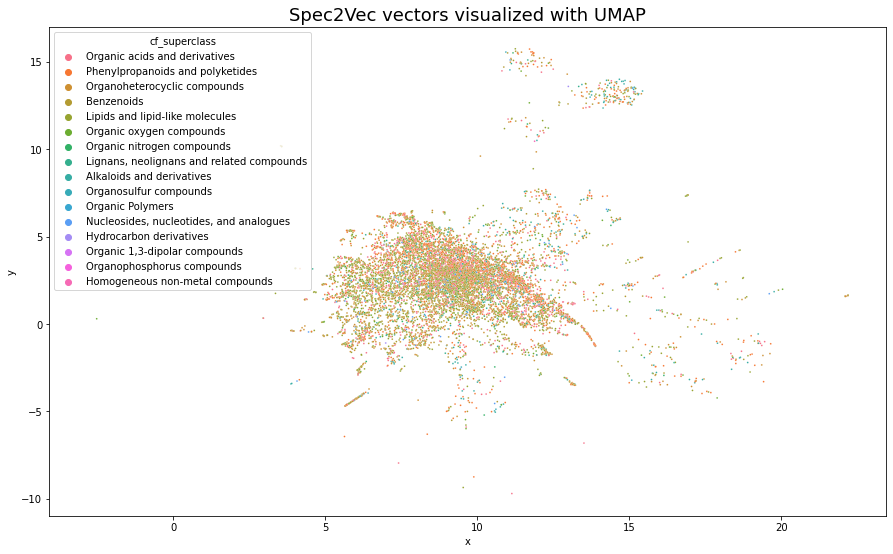

In [120]:
# Plot UMAP of selected data
plt.figure(figsize=(15,9))
sns.scatterplot(data = umap_df.iloc[selection.index,:], x="x", y="y", hue = "cf_superclass", alpha = 1, s= 3).set_title("Spec2Vec vectors visualized with UMAP", fontsize = 18)

Text(0.5, 1.0, 'Spec2Vec vectors visualized with t-SNE')

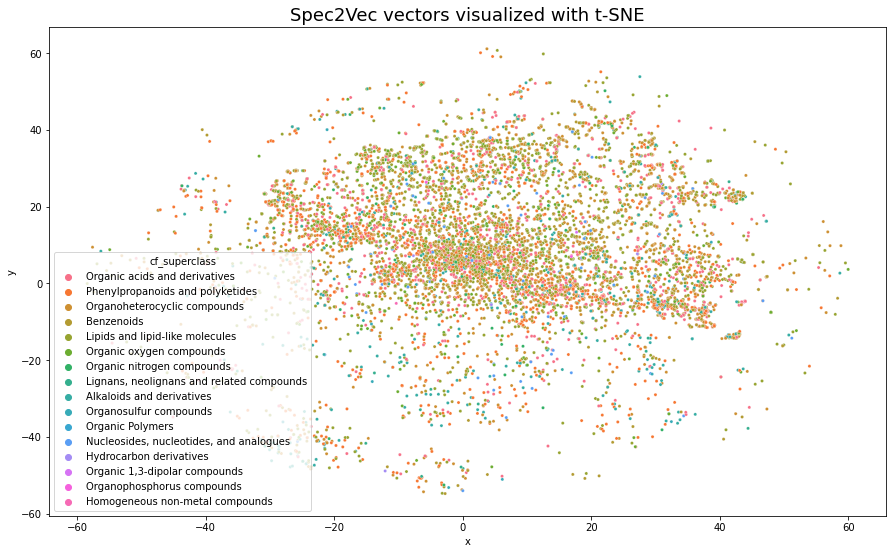

In [95]:
# Plot UMAP of selected data
plt.figure(figsize=(15,9))
sns.scatterplot(data = tsne_df.iloc[selection.index,:], x="x", y="y", hue = "cf_superclass", alpha = 1, s=10).set_title("Spec2Vec vectors visualized with t-SNE", fontsize = 18)

# Comparison of HCD and CID Velos instruments

In [133]:
# We'll start by comparing the spectra of the most popular HCD and CID instruments, which are the Velos platforms
# These are also nice instruments to start with, because they have been used to analyse the same compounds

selected_instruments = ["LC-ESI-HCD; Velos", "LC-ESI-CID; Velos"]
HCD_selection = spectrum_metadata.query('instrument == @selected_instruments[0]')
CID_selection = spectrum_metadata.query('instrument == @selected_instruments[1]')

# We'll also save a selection with unique inchikeys only
HCD_selection_nodup = HCD_selection.drop_duplicates(subset = "inchikey", keep = "first")
CID_selection_nodup = CID_selection.drop_duplicates(subset = "inchikey", keep = "first")

In [167]:
len(HCD_selection_nodup)

319

In [124]:
HCD_selection["cf_superclass"].value_counts()

Lipids and lipid-like molecules    6893
Organic nitrogen compounds            8
Name: cf_superclass, dtype: int64

In [125]:
HCD_selection["npc_superclass_results"].value_counts()

Glycerophospholipids    6398
Spingolipids            1437
Meroterpenoids            75
Name: npc_superclass_results, dtype: int64

Text(0.5, 1.0, 'LC-ESI-CID; Velos')

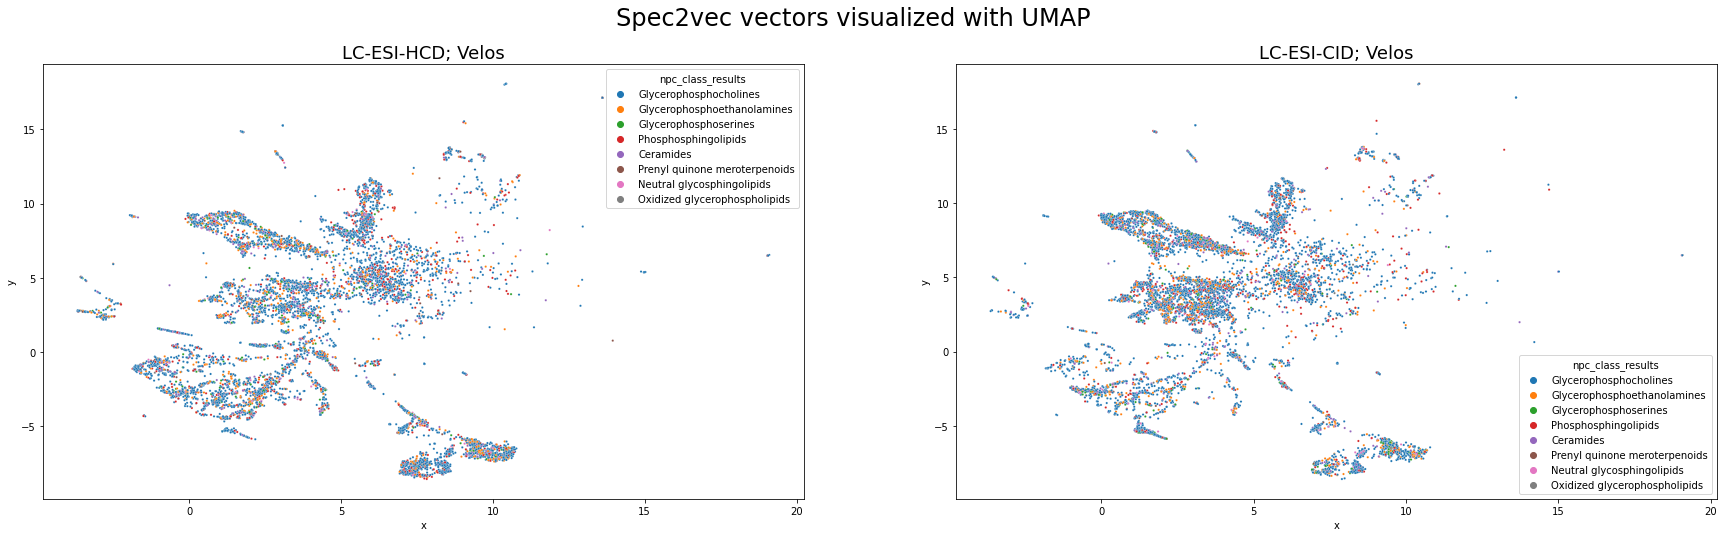

In [168]:
# Plot results
fig, ax = plt.subplots(1,2, figsize = (30,8)); fig.suptitle('Spec2vec vectors visualized with UMAP', fontsize = 24)
sns.scatterplot(data = umap_df.iloc[HCD_selection.index,:], x="x", y="y", hue = "npc_class_results", alpha = 1, s=5, ax = ax[0]).set_title(selected_instruments[0], fontsize = 18)
sns.scatterplot(data = umap_df.iloc[CID_selection.index,:], x="x", y="y", hue = "npc_class_results", alpha = 1, s=5, ax = ax[1]).set_title(selected_instruments[1], fontsize = 18)

Text(0.5, 1.0, 'LC-ESI-CID; Velos')

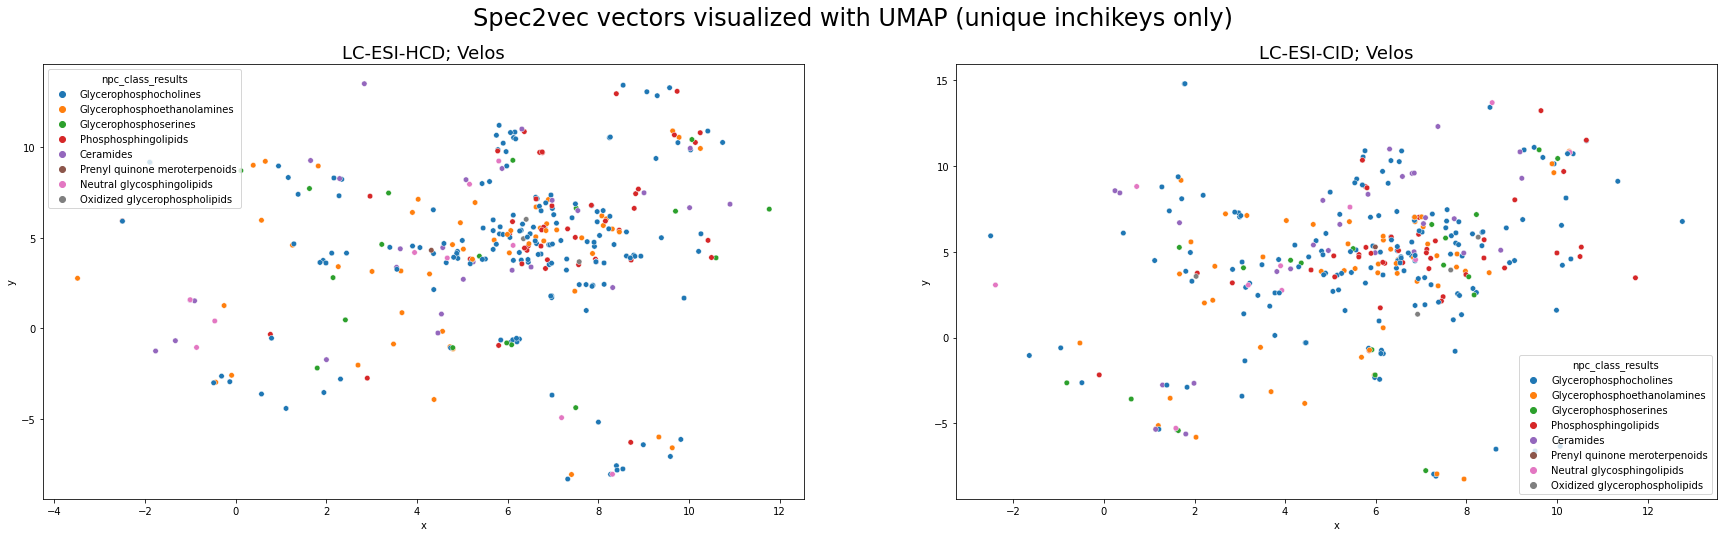

In [175]:
fig, ax = plt.subplots(1,2, figsize = (30,8)); fig.suptitle('Spec2vec vectors visualized with UMAP (unique inchikeys only)', fontsize = 24)
sns.scatterplot(data = umap_df.iloc[HCD_selection_nodup.index,:], x="x", y="y", hue = "npc_class_results", alpha = 1, s=30, ax = ax[0]).set_title(selected_instruments[0], fontsize = 18)
sns.scatterplot(data = umap_df.iloc[CID_selection_nodup.index,:], x="x", y="y", hue = "npc_class_results", alpha = 1, s=30, ax = ax[1]).set_title(selected_instruments[1], fontsize = 18)

Text(0.5, 1.0, 'LC-ESI-CID; Velos')

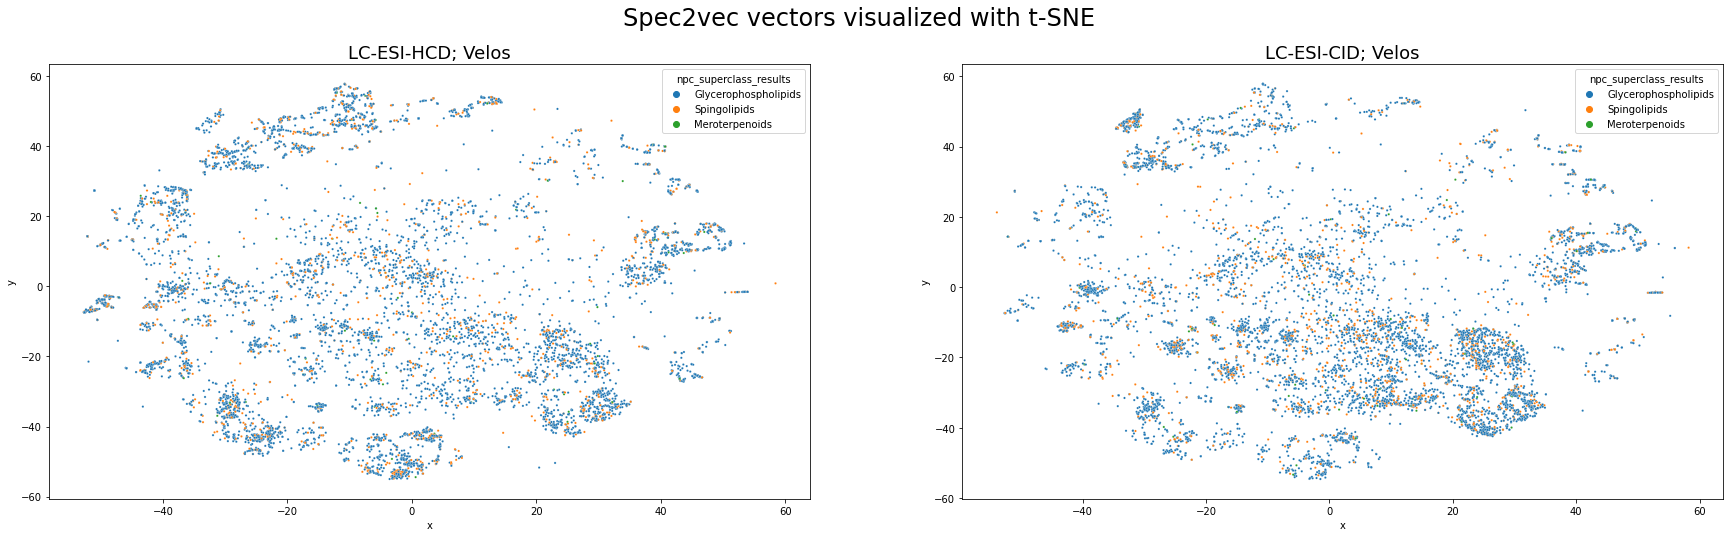

In [118]:
# Plot results
fig, ax = plt.subplots(1,2, figsize = (30,8)); fig.suptitle('Spec2vec vectors visualized with t-SNE', fontsize = 24)
sns.scatterplot(data = tsne_df.iloc[HCD_selection.index,:], x="x", y="y", hue = "npc_superclass_results", alpha = 1, s=5, ax = ax[0]).set_title(selected_instruments[0], fontsize = 18)
sns.scatterplot(data = tsne_df.iloc[CID_selection.index,:], x="x", y="y", hue = "npc_superclass_results", alpha = 1, s=5, ax = ax[1]).set_title(selected_instruments[1], fontsize = 18)

Text(0.5, 1.0, 'LC-ESI-CID; Velos')

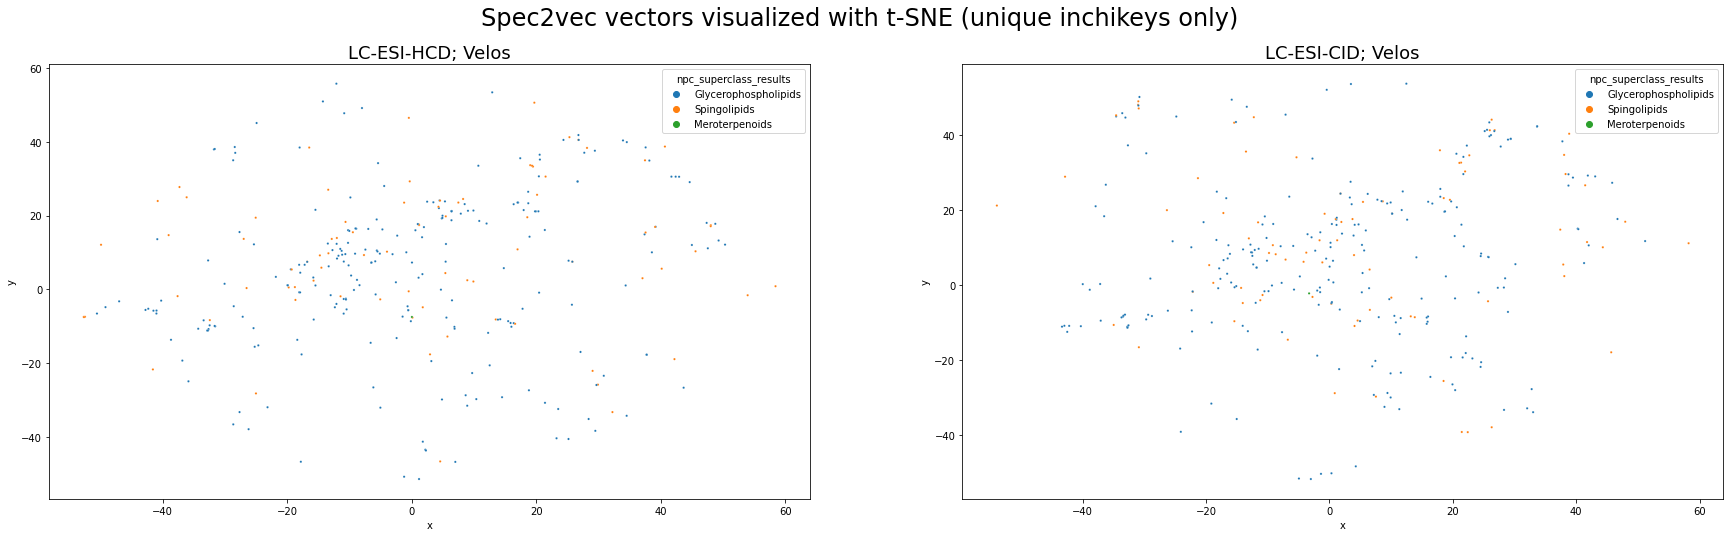

In [154]:
fig, ax = plt.subplots(1,2, figsize = (30,8)); fig.suptitle('Spec2vec vectors visualized with t-SNE (unique inchikeys only)', fontsize = 24)
sns.scatterplot(data = tsne_df.iloc[HCD_selection_nodup.index,:], x="x", y="y", hue = "npc_superclass_results", alpha = 1, s=5, ax = ax[0]).set_title(selected_instruments[0], fontsize = 18)
sns.scatterplot(data = tsne_df.iloc[CID_selection_nodup.index,:], x="x", y="y", hue = "npc_superclass_results", alpha = 1, s=5, ax = ax[1]).set_title(selected_instruments[1], fontsize = 18)